# Import functions

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

# Create enviroment

In [2]:
# Create simulation environment
simulation_start = datetime.datetime.now()

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

# Make locations


In [3]:
# The generic site class
Site = type('Site', (core.Identifiable, # Give it a name
                     core.Log,          # Allow logging of all discrete events
                     core.Locatable,    # Add coordinates to extract distance information and visualize
                     core.HasContainer, # Add information on the material available at the site
                     core.HasResource), # Add information on serving equipment
            {})    

# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Winlocatie",           # The name of the site
                  "geometry": location_from_site, # The coordinates of the project site
                  "capacity": 500_000,            # The capacity of the site
                  "level": 500_000}               # The actual volume of the site


# The two objects used for the simulation
from_site = Site(**data_from_site)

# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)     # lon, lat

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Dumplocatie",            # The name of the site
                "geometry": location_to_site,     # The coordinates of the project site
                "capacity": 500_000,              # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

to_site   = Site(**data_to_site)

sites = [from_site, to_site]

# Make a Hopper

In [4]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    ),                 # Initialize spill terms
                                   {})

# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

def compute_loading(rate):
    return lambda x: x / rate

def compute_unloading(rate):
    return lambda x: x / rate

# TSHD variables
data_hopper = {"env": my_env,                                       # The simpy environment 
               "name": "Hopper 01",                                 # Name
               "geometry": location_from_site,                      # It starts at the "from site"
               "loading_func": compute_loading(1.5),                # Loading rate
               "unloading_func": compute_unloading(1.5),            # Unloading rate
               "capacity": 5_000,                                   # Capacity of the hopper - "Beunvolume"
               "compute_v": compute_v_provider(5, 4.5)}             # Variable speed 

# The simulation object
hopper = TransportProcessingResource(**data_hopper)

# Create activity

In [5]:
# Create activity
activity = model.Activity(env = my_env,           # The simpy environment defined in the first cel
                          name = "Soil movement", # We are moving soil
                          origin = from_site,     # We originate from the from_site
                          destination = to_site,  # And therefore travel to the to_site
                          loader = hopper,        # The benefit of a TSHD, all steps can be done
                          mover = hopper,         # The benefit of a TSHD, all steps can be done
                          unloader = hopper,      # The benefit of a TSHD, all steps can be done
                          start_condition = None) # We can start right away and do not stop

# Run

In [6]:
my_env.run()

print("\n*** Installation of dike finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))

T=1551171195.00 Start condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie started
T=1552234057.51 Stop condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie complete

*** Installation of dike finished in 12 days, 7:14:22 ***


# Post Process

In [7]:
vessels = [hopper]
activities = ['loading', 'unloading', 'sailing full', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

In [8]:
print(to_site.container.capacity)

500000


In [28]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

[((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((0, 2), (0, 3)), ((0, 3), (1, 3)), ((0, 3), (0, 4)), ((0, 4), (1, 4)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((1, 2), (1, 3)), ((1, 3), (2, 3)), ((1, 3), (1, 4)), ((1, 4), (2, 4)), ((2, 0), (3, 0)), ((2, 0), (2, 1)), ((2, 1), (3, 1)), ((2, 1), (2, 2)), ((2, 2), (3, 2)), ((2, 2), (2, 3)), ((2, 3), (3, 3)), ((2, 3), (2, 4)), ((2, 4), (3, 4)), ((3, 0), (4, 0)), ((3, 0), (3, 1)), ((3, 1), (4, 1)), ((3, 1), (3, 2)), ((3, 2), (4, 2)), ((3, 2), (3, 3)), ((3, 3), (4, 3)), ((3, 3), (3, 4)), ((3, 4), (4, 4)), ((4, 0), (4, 1)), ((4, 1), (4, 2)), ((4, 2), (4, 3)), ((4, 3), (4, 4))]
8
[(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]


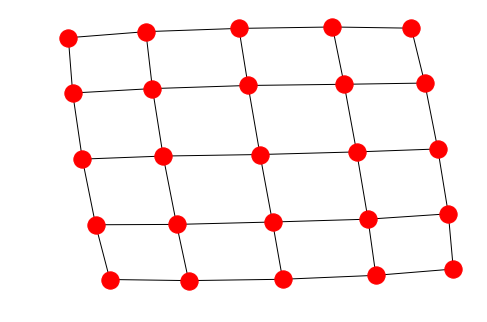

In [63]:
G=nx.grid_2d_graph(5, 5, periodic=False, create_using=None)
print(G)
nx.draw(G)

length,path=nx.bidirectional_dijkstra(G,(0 , 0),(4, 4))

print(length)
print(path)